## Intro

In [5]:
!pip install ktrain
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [6]:
import ktrain
from ktrain import vision as vis

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Data

Next, we will load and preprocess the image data for training and validation.  *ktrain* can load images and associated labels from a variety of source:


- `images_from_folder`:  labels are represented as subfolders containing images [ [example notebook] ](https://github.com/amaiya/ktrain/blob/master/examples/vision/dogs_vs_cats-ResNet50.ipynb)
- `images_from_csv`: labels are mapped to images in a CSV file [ [example notebook](https://github.com/amaiya/ktrain/blob/master/examples/vision/planet-ResNet50.ipynb) ]
- `images_from_fname`: labels are included as part of the filename and must be extracted using a regular expression [ [example notebook](https://github.com/amaiya/ktrain/blob/master/examples/vision/pets-ResNet50.ipynb) ]
- `images_from_array`: images and labels are stored in array [ [example notebook](https://github.com/amaiya/ktrain/blob/master/examples/vision/mnist-images_from_array_example.ipynb) ]


Here, we use the ```images_from_folder``` function to load the data as a generator (i.e., DirectoryIterator object).  This function assumes the following directory structure:
```
  ├── datadir
    │   ├── train
    │   │   ├── class0       # folder containing documents of class 0
    │   │   ├── class1       # folder containing documents of class 1
    │   │   ├── class2       # folder containing documents of class 2
    │   │   └── classN       # folder containing documents of class N
    │   └── test
    │       ├── class0       # folder containing documents of class 0
    │       ├── class1       # folder containing documents of class 1
    │       ├── class2       # folder containing documents of class 2
    │       └── classN       # folder containing documents of class N
```


The *train_test_names* argument can be used, if the train and test subfolders are named differently (e.g., *test* folder is called *valid*).  Here, we load a dataset of cat and dog images, which can be obtained from [here](https://www.kaggle.com/c/dogs-vs-cats/data).  The DATADIR variale should be set to the path to the extracted folder.  The **data_aug** parameter can be used to employ [data augmentation](https://arxiv.org/abs/1712.04621). We set this parameter using the ```get_data_aug``` function, which returns a default data augmentation with ```horizontal_flip=True``` as the only change to the defaults.  See [Keras documentation](https://keras.io/preprocessing/image/#imagedatagenerator-class) for a full set of agumentation parameters.  Finally, we pass the requested target size (224,224) and color mode (rgb, which is a 3-channel image). The image will be resized or converted appropriately based on the values supplied.  A target size of 224 by 224 is  typically used when using a network pretrained on ImageNet, which we do next.  The ```images_from_folder``` function returns generators for both the training and validation data in addition an instance of ```ktrain.vision.ImagePreprocessor```, which can be used to preprocess raw data when making predictions for new examples.  This will be demonstrated later.

In [ ]:
DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'val'],
                                              target_size=(224,224), color_mode='rgb')

color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


Let's examine some sample cat and dog images from the training set:

sample control images:


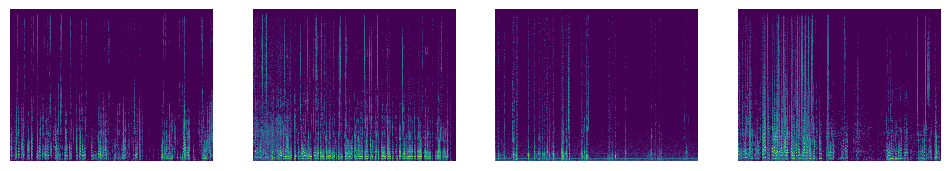

In [ ]:
print('sample control images:')
vis.show_random_images('/content/drive/MyDrive/spectrograms/train/control')

sample dementia images:


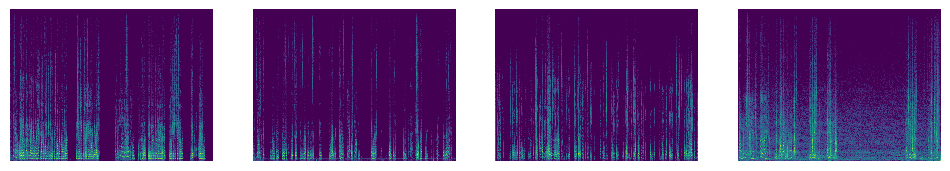

In [ ]:
print('sample dementia images:')
vis.show_random_images('/content/drive/MyDrive/spectrograms/train/dementia')

Next, we use the ```image_classifier``` function to load a **ResNet50** model pre-trained on [ImageNet](http://www.image-net.org/). For more information on using pretrained networks, see this [blog post](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html). By default, all layers except the randomly initialized custom Dense layers on top are frozen (i.e., trainable).  We, then, wrap the model and data in a Learner object. We specify 4 CPU workers to load batches during training, disable multiprocessing, and use a batch size of 64. You can change these values based on your system specification to see what yields the best peformance.

In [ ]:
# let's print the available precanned image classification models in ktrain
vis.print_image_classifiers()

pretrained_resnet50: 50-layer Residual Network (pretrained on ImageNet)
resnet50: 50-layer Resididual Network (randomly initialized) [https://arxiv.org/abs/1512.03385]
pretrained_mobilenet: MobileNet Neural Network (pretrained on ImageNet)
mobilenet: MobileNet Neural Network (randomly initialized) [https://arxiv.org/abs/1704.04861]
pretrained_mobilenetv3: MobileNetV3-Small Neural Network (pretrained on ImageNet)
mobilenetv3: MobileNetV3-Small Neural Network (randomly initialized) [https://arxiv.org/abs/1905.02244]
pretrained_inception: Inception Version 3  (pretrained on ImageNet)
inception: Inception Version 3 (randomly initialized) [http://arxiv.org/abs/1512.00567]
pretrained_efficientnetb1: EfficientNet-B1 Neural Network (pretrained on ImageNet)
efficientnetb1: EfficientNet-B1 Neural Network (pretrained on ImageNet) [https://arxiv.org/abs/1905.11946]
pretrained_efficientnetb7: EfficientNet-B7 Neural Network (pretrained on ImageNet)
efficientnetb7: EfficientNet-B7 Neural Network (pre

## MobileNet

In [ ]:
model = vis.image_classifier('mobilenet', train_data, val_data)
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data,
                             workers=8, use_multiprocessing=False, batch_size=4)

Is Multi-Label? False
Is Regression? False
mobilenet model created.


You use the ```print_layers``` function to examine the layers of the created network.

As shown before, we use the Learning Rate Finder in *ktrain* to find a good initial learning rate.

In [ ]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/ktrain/core.py:620: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  warnings.warn(


Epoch 1/5
21/21 [==============================] - 8s 188ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 2/5
21/21 [==============================] - 4s 150ms/step - loss: 0.6932 - accuracy: 0.4756
Epoch 3/5
21/21 [==============================] - 5s 196ms/step - loss: 0.6933 - accuracy: 0.5122
Epoch 4/5
21/21 [==============================] - 5s 190ms/step - loss: 0.6987 - accuracy: 0.3902
Epoch 5/5
21/21 [==============================] - 4s 153ms/step - loss: 0.8089 - accuracy: 0.3902


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


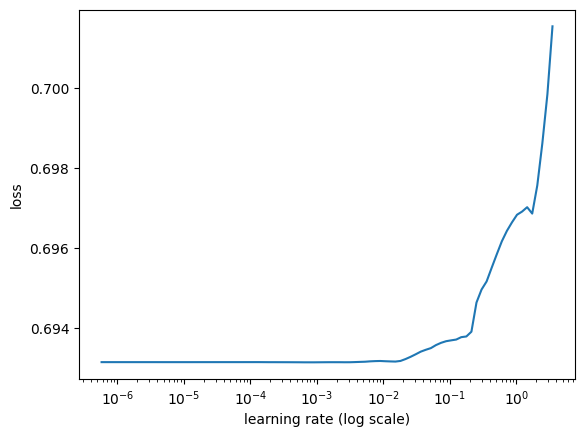

In [ ]:
learner.lr_plot()

Finally, we will use the ```autofit``` method to train our model using a [triangular learning rate policy](https://arxiv.org/pdf/1506.01186.pdf). Since we have not specified the number of epochs, the maximum learning
rate will be periodically reduced when validation loss fails to decrease and eventually stop automatically.

Our final validation accuracy is **99.55%** first occuring at the 8th epoch during this run.

In [ ]:
learner.fit_onecycle(lr=1e-4, epochs=100)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/100
22/22 [==============================] - 19s 752ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/100
22/22 [==============================] - 8s 333ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/100
22/22 [==============================] - 10s 464ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/100
22/22 [==============================] - 7s 273ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/100
22/22 [==============================] - 7s 310ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/100
22/22 [==============================] - 7s 288ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/100
22/22 [==============================] - 9s 400ms/step - loss: 0

In [ ]:
DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'test'],
                                              target_size=(224,224), color_mode='rgb')

color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


As can be seen, the final validation accuracy of our model is **99.55%**.

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('/content/drive/MyDrive/spectrograms/mobilenet')

predictor = ktrain.load_predictor('/content/drive/MyDrive/spectrograms/mobilenet')

predictor.predict_folder('/content/drive/MyDrive/spectrograms/test/0')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 48 images belonging to 1 classes.


[('0/S160.png', 'dementia'),
 ('0/S161.png', 'dementia'),
 ('0/S162.png', 'dementia'),
 ('0/S163.png', 'dementia'),
 ('0/S164.png', 'dementia'),
 ('0/S165.png', 'dementia'),
 ('0/S166.png', 'dementia'),
 ('0/S167.png', 'dementia'),
 ('0/S168.png', 'dementia'),
 ('0/S169.png', 'dementia'),
 ('0/S170.png', 'dementia'),
 ('0/S171.png', 'dementia'),
 ('0/S172.png', 'dementia'),
 ('0/S173.png', 'dementia'),
 ('0/S174.png', 'dementia'),
 ('0/S175.png', 'dementia'),
 ('0/S176.png', 'dementia'),
 ('0/S177.png', 'dementia'),
 ('0/S178.png', 'dementia'),
 ('0/S179.png', 'dementia'),
 ('0/S180.png', 'dementia'),
 ('0/S181.png', 'dementia'),
 ('0/S182.png', 'dementia'),
 ('0/S183.png', 'dementia'),
 ('0/S184.png', 'dementia'),
 ('0/S185.png', 'dementia'),
 ('0/S186.png', 'dementia'),
 ('0/S187.png', 'dementia'),
 ('0/S188.png', 'dementia'),
 ('0/S189.png', 'dementia'),
 ('0/S190.png', 'dementia'),
 ('0/S191.png', 'dementia'),
 ('0/S192.png', 'dementia'),
 ('0/S193.png', 'dementia'),
 ('0/S194.png'

In [ ]:
DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'val'],
                                              target_size=(224,224), color_mode='rgb')

DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'test'],
                                              target_size=(224,224), color_mode='rgb')

model = vis.image_classifier('mobilenet', train_data, val_data)
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data,
                             workers=8, use_multiprocessing=False, batch_size=6)

learner.fit_onecycle(lr=1e-4, epochs=100)

color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Is Multi-Label? False
Is Regression? False
mobilenet model created.


begin training using onecycle policy with max lr of 0.0001...
Epoch 1/100
15/15 [==============================] - 23s 1s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.0000e+00
Epoch 2/100
15/15 [==============================] - 11s 721ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.0000e+00
Epoch 3/100
15/15 [==============================] - 9s 526ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 1.0000
Epoch 4/100
15/15 [==============================] - 15s 969ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


ValueError: Unable to create dataset (name already exists)

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
#predictor.save('/content/drive/MyDrive/spectrograms/mobilenet')
#predictor = ktrain.load_predictor('/content/drive/MyDrive/spectrograms/mobilenet')
predictor.predict_folder('/content/drive/MyDrive/spectrograms/test/0')

Found 48 images belonging to 1 classes.


[('0/S160.png', 'dementia'),
 ('0/S161.png', 'dementia'),
 ('0/S162.png', 'dementia'),
 ('0/S163.png', 'dementia'),
 ('0/S164.png', 'dementia'),
 ('0/S165.png', 'dementia'),
 ('0/S166.png', 'dementia'),
 ('0/S167.png', 'dementia'),
 ('0/S168.png', 'dementia'),
 ('0/S169.png', 'dementia'),
 ('0/S170.png', 'dementia'),
 ('0/S171.png', 'dementia'),
 ('0/S172.png', 'dementia'),
 ('0/S173.png', 'dementia'),
 ('0/S174.png', 'dementia'),
 ('0/S175.png', 'dementia'),
 ('0/S176.png', 'dementia'),
 ('0/S177.png', 'dementia'),
 ('0/S178.png', 'dementia'),
 ('0/S179.png', 'dementia'),
 ('0/S180.png', 'dementia'),
 ('0/S181.png', 'dementia'),
 ('0/S182.png', 'dementia'),
 ('0/S183.png', 'dementia'),
 ('0/S184.png', 'dementia'),
 ('0/S185.png', 'dementia'),
 ('0/S186.png', 'dementia'),
 ('0/S187.png', 'dementia'),
 ('0/S188.png', 'dementia'),
 ('0/S189.png', 'dementia'),
 ('0/S190.png', 'dementia'),
 ('0/S191.png', 'dementia'),
 ('0/S192.png', 'dementia'),
 ('0/S193.png', 'dementia'),
 ('0/S194.png'

In [ ]:
DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'val'],
                                              target_size=(224,224), color_mode='rgb')

DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'test'],
                                              target_size=(224,224), color_mode='rgb')

model = vis.image_classifier('mobilenet', train_data, val_data)
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data,
                             workers=8, use_multiprocessing=False, batch_size=8)

learner.fit_onecycle(lr=1e-4, epochs=100)

predictor = ktrain.get_predictor(learner.model, preproc)
predictor.predict_folder('/content/drive/MyDrive/spectrograms/test/0')

color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Is Multi-Label? False
Is Regression? False
mobilenet model created.


begin training using onecycle policy with max lr of 0.0001...
Epoch 1/100
11/11 [==============================] - 14s 1s/step - loss: 0.6932 - accuracy: 0.4302 - val_loss: 0.6931 - val_accuracy: 1.0000
Epoch 2/100
11/11 [==============================] - 11s 923ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.0000e+00
Epoch 3/100
11/11 [==============================] - 9s 728ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.0000e+00
Epoch 4/100
11/11 [==============================] - 8s 643ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 

[('0/S160.png', 'dementia'),
 ('0/S161.png', 'dementia'),
 ('0/S162.png', 'dementia'),
 ('0/S163.png', 'dementia'),
 ('0/S164.png', 'dementia'),
 ('0/S165.png', 'dementia'),
 ('0/S166.png', 'dementia'),
 ('0/S167.png', 'dementia'),
 ('0/S168.png', 'dementia'),
 ('0/S169.png', 'dementia'),
 ('0/S170.png', 'dementia'),
 ('0/S171.png', 'dementia'),
 ('0/S172.png', 'dementia'),
 ('0/S173.png', 'dementia'),
 ('0/S174.png', 'dementia'),
 ('0/S175.png', 'dementia'),
 ('0/S176.png', 'dementia'),
 ('0/S177.png', 'dementia'),
 ('0/S178.png', 'dementia'),
 ('0/S179.png', 'dementia'),
 ('0/S180.png', 'dementia'),
 ('0/S181.png', 'dementia'),
 ('0/S182.png', 'dementia'),
 ('0/S183.png', 'dementia'),
 ('0/S184.png', 'dementia'),
 ('0/S185.png', 'dementia'),
 ('0/S186.png', 'dementia'),
 ('0/S187.png', 'dementia'),
 ('0/S188.png', 'dementia'),
 ('0/S189.png', 'dementia'),
 ('0/S190.png', 'dementia'),
 ('0/S191.png', 'dementia'),
 ('0/S192.png', 'dementia'),
 ('0/S193.png', 'dementia'),
 ('0/S194.png'

In [ ]:
DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'val'],
                                              target_size=(224,224), color_mode='rgb')

DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'test'],
                                              target_size=(224,224), color_mode='rgb')

model = vis.image_classifier('mobilenet', train_data, val_data)
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data,
                             workers=8, use_multiprocessing=False, batch_size=12)

learner.fit_onecycle(lr=1e-4, epochs=100)

predictor = ktrain.get_predictor(learner.model, preproc)
predictor.predict_folder('/content/drive/MyDrive/spectrograms/test/0')

color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Is Multi-Label? False
Is Regression? False
mobilenet model created.


begin training using onecycle policy with max lr of 0.0001...
Epoch 1/100
8/8 [==============================] - 13s 1s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 12s 2s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.0000e+00
Epoch 3/100
8/8 [==============================] - 10s 1s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.0000e+00
Epoch 4/100
8/8 [==============================] - 10s 1s/step - loss: 0.6932 - accuracy: 0.4767 - val_loss: 0.6930 - val_accuracy: 1.0000
Epoc

[('0/S160.png', 'dementia'),
 ('0/S161.png', 'dementia'),
 ('0/S162.png', 'dementia'),
 ('0/S163.png', 'dementia'),
 ('0/S164.png', 'dementia'),
 ('0/S165.png', 'dementia'),
 ('0/S166.png', 'dementia'),
 ('0/S167.png', 'dementia'),
 ('0/S168.png', 'dementia'),
 ('0/S169.png', 'dementia'),
 ('0/S170.png', 'dementia'),
 ('0/S171.png', 'dementia'),
 ('0/S172.png', 'dementia'),
 ('0/S173.png', 'dementia'),
 ('0/S174.png', 'dementia'),
 ('0/S175.png', 'dementia'),
 ('0/S176.png', 'dementia'),
 ('0/S177.png', 'dementia'),
 ('0/S178.png', 'dementia'),
 ('0/S179.png', 'dementia'),
 ('0/S180.png', 'dementia'),
 ('0/S181.png', 'dementia'),
 ('0/S182.png', 'dementia'),
 ('0/S183.png', 'dementia'),
 ('0/S184.png', 'dementia'),
 ('0/S185.png', 'dementia'),
 ('0/S186.png', 'dementia'),
 ('0/S187.png', 'dementia'),
 ('0/S188.png', 'dementia'),
 ('0/S189.png', 'dementia'),
 ('0/S190.png', 'dementia'),
 ('0/S191.png', 'dementia'),
 ('0/S192.png', 'dementia'),
 ('0/S193.png', 'dementia'),
 ('0/S194.png'

## Default_cnn

In [ ]:
DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'val'],
                                              target_size=(224,224), color_mode='rgb')

DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'test'],
                                              target_size=(224,224), color_mode='rgb')

model = vis.image_classifier('default_cnn', train_data, val_data)
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data,
                             workers=8, use_multiprocessing=False, batch_size=4)

learner.fit_onecycle(lr=1e-4, epochs=100)

predictor = ktrain.get_predictor(learner.model, preproc)
predictor.predict_folder('/content/drive/MyDrive/spectrograms/test/0')

color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Is Multi-Label? False
Is Regression? False
default_cnn model created.


begin training using onecycle policy with max lr of 0.0001...
Epoch 1/100
22/22 [==============================] - 64s 3s/step - loss: 0.7851 - accuracy: 0.6163 - val_loss: 23.2903 - val_accuracy: 0.0000e+00
Epoch 2/100
22/22 [==============================] - 60s 3s/step - loss: 0.7295 - accuracy: 0.6512 - val_loss: 13.2129 - val_accuracy: 0.0000e+00
Epoch 3/100
22/22 [==============================] - 55s 2s/step - loss: 0.7277 - accuracy: 0.6163 - val_loss: 3.9389 - val_accuracy: 0.0000e+00
Epoch 4/100
22/22 [==============================] - 57s 3s/step - loss: 0.7279 - accuracy: 0.5930 - val_loss: 1.4794 - val_accuracy:

[('0/S160.png', 'control'),
 ('0/S161.png', 'control'),
 ('0/S162.png', 'control'),
 ('0/S163.png', 'control'),
 ('0/S164.png', 'control'),
 ('0/S165.png', 'control'),
 ('0/S166.png', 'control'),
 ('0/S167.png', 'control'),
 ('0/S168.png', 'dementia'),
 ('0/S169.png', 'control'),
 ('0/S170.png', 'control'),
 ('0/S171.png', 'dementia'),
 ('0/S172.png', 'control'),
 ('0/S173.png', 'control'),
 ('0/S174.png', 'dementia'),
 ('0/S175.png', 'dementia'),
 ('0/S176.png', 'dementia'),
 ('0/S177.png', 'dementia'),
 ('0/S178.png', 'dementia'),
 ('0/S179.png', 'dementia'),
 ('0/S180.png', 'dementia'),
 ('0/S181.png', 'dementia'),
 ('0/S182.png', 'dementia'),
 ('0/S183.png', 'dementia'),
 ('0/S184.png', 'control'),
 ('0/S185.png', 'dementia'),
 ('0/S186.png', 'control'),
 ('0/S187.png', 'dementia'),
 ('0/S188.png', 'control'),
 ('0/S189.png', 'control'),
 ('0/S190.png', 'dementia'),
 ('0/S191.png', 'dementia'),
 ('0/S192.png', 'dementia'),
 ('0/S193.png', 'control'),
 ('0/S194.png', 'control'),
 ('

In [ ]:
y_test = [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0]
predictions = [('0/S160.png', 'control'),
 ('0/S161.png', 'control'),
 ('0/S162.png', 'control'),
 ('0/S163.png', 'control'),
 ('0/S164.png', 'control'),
 ('0/S165.png', 'control'),
 ('0/S166.png', 'control'),
 ('0/S167.png', 'control'),
 ('0/S168.png', 'dementia'),
 ('0/S169.png', 'control'),
 ('0/S170.png', 'control'),
 ('0/S171.png', 'dementia'),
 ('0/S172.png', 'control'),
 ('0/S173.png', 'control'),
 ('0/S174.png', 'dementia'),
 ('0/S175.png', 'dementia'),
 ('0/S176.png', 'dementia'),
 ('0/S177.png', 'dementia'),
 ('0/S178.png', 'dementia'),
 ('0/S179.png', 'dementia'),
 ('0/S180.png', 'dementia'),
 ('0/S181.png', 'dementia'),
 ('0/S182.png', 'dementia'),
 ('0/S183.png', 'dementia'),
 ('0/S184.png', 'control'),
 ('0/S185.png', 'dementia'),
 ('0/S186.png', 'control'),
 ('0/S187.png', 'dementia'),
 ('0/S188.png', 'control'),
 ('0/S189.png', 'control'),
 ('0/S190.png', 'dementia'),
 ('0/S191.png', 'dementia'),
 ('0/S192.png', 'dementia'),
 ('0/S193.png', 'control'),
 ('0/S194.png', 'control'),
 ('0/S195.png', 'dementia'),
 ('0/S196.png', 'control'),
 ('0/S197.png', 'control'),
 ('0/S198.png', 'control'),
 ('0/S199.png', 'control'),
 ('0/S200.png', 'control'),
 ('0/S201.png', 'control'),
 ('0/S202.png', 'dementia'),
 ('0/S203.png', 'control'),
 ('0/S204.png', 'control'),
 ('0/S205.png', 'control'),
 ('0/S206.png', 'control'),
 ('0/S207.png', 'dementia')]

predictions_binary = [1 if label == 'dementia' else 0 for _, label in predictions]

# Calculando a porcentagem de acertos
correct = sum([1 for correct, pred in zip(y_test, predictions_binary) if correct == pred])
accuracy = (correct / len(y_test)) * 100
print(accuracy)

54.166666666666664


In [ ]:
DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'val'],
                                              target_size=(224,224), color_mode='rgb')

DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'test'],
                                              target_size=(224,224), color_mode='rgb')

model = vis.image_classifier('default_cnn', train_data, val_data)
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data,
                             workers=8, use_multiprocessing=False, batch_size=6)

learner.fit_onecycle(lr=1e-4, epochs=100)

predictor = ktrain.get_predictor(learner.model, preproc)
predictions = predictor.predict_folder('/content/drive/MyDrive/spectrograms/test/0')

predictions_binary = [1 if label == 'dementia' else 0 for _, label in predictions]

# Calculando a porcentagem de acertos
correct = sum([1 for correct, pred in zip(y_test, predictions_binary) if correct == pred])
accuracy = (correct / len(y_test)) * 100
print(accuracy)

color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Is Multi-Label? False
Is Regression? False
default_cnn model created.


begin training using onecycle policy with max lr of 0.0001...
Epoch 1/100
15/15 [==============================] - 6s 333ms/step - loss: 1.0581 - accuracy: 0.4535 - val_loss: 2.9429 - val_accuracy: 0.0000e+00
Epoch 2/100
15/15 [==============================] - 8s 504ms/step - loss: 0.7964 - accuracy: 0.6163 - val_loss: 0.6749 - val_accuracy: 0.7292
Epoch 3/100
15/15 [==============================] - 11s 669ms/step - loss: 1.0344 - accuracy: 0.5814 - val_loss: 0.2109 - val_accuracy: 0.9583
Epoch 4/100
15/15 [==============================] - 8s 497ms/step - loss: 0.7998 - accuracy: 0.6163 - val_loss: 0.0861 - val_accuracy: 

In [ ]:
DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'val'],
                                              target_size=(224,224), color_mode='rgb')

DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'test'],
                                              target_size=(224,224), color_mode='rgb')

model = vis.image_classifier('default_cnn', train_data, val_data)
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data,
                             workers=8, use_multiprocessing=False, batch_size=8)

learner.fit_onecycle(lr=1e-4, epochs=100)

predictor = ktrain.get_predictor(learner.model, preproc)
predictions = predictor.predict_folder('/content/drive/MyDrive/spectrograms/test/0')

y_test = [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0]
predictions_binary = [1 if label == 'dementia' else 0 for _, label in predictions]

# Calculando a porcentagem de acertos
correct = sum([1 for correct, pred in zip(y_test, predictions_binary) if correct == pred])
accuracy = (correct / len(y_test)) * 100
print(accuracy)

color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Is Multi-Label? False
Is Regression? False
default_cnn model created.


begin training using onecycle policy with max lr of 0.0001...
Epoch 1/100
11/11 [==============================] - 89s 8s/step - loss: 0.9750 - accuracy: 0.5814 - val_loss: 2.2644 - val_accuracy: 0.2500
Epoch 2/100
11/11 [==============================] - 43s 4s/step - loss: 0.8766 - accuracy: 0.5581 - val_loss: 0.8050 - val_accuracy: 0.6250
Epoch 3/100
11/11 [==============================] - 44s 4s/step - loss: 0.8269 - accuracy: 0.5349 - val_loss: 1.7560 - val_accuracy: 0.2917
Epoch 4/100
11/11 [==============================] - 43s 4s/step - loss: 0.7733 - accuracy: 0.6047 - val_loss: 2.3143 - val_accuracy: 0.2083
Epoch 

In [ ]:
DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'val'],
                                              target_size=(224,224), color_mode='rgb')

DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'test'],
                                              target_size=(224,224), color_mode='rgb')

model = vis.image_classifier('default_cnn', train_data, val_data)
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data,
                             workers=8, use_multiprocessing=False, batch_size=12)

learner.fit_onecycle(lr=1e-4, epochs=100)

predictor = ktrain.get_predictor(learner.model, preproc)
predictions = predictor.predict_folder('/content/drive/MyDrive/spectrograms/test/0')

predictions_binary = [1 if label == 'dementia' else 0 for _, label in predictions]

# Calculando a porcentagem de acertos
correct = sum([1 for correct, pred in zip(y_test, predictions_binary) if correct == pred])
accuracy = (correct / len(y_test)) * 100
print(accuracy)

color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Is Multi-Label? False
Is Regression? False
default_cnn model created.


begin training using onecycle policy with max lr of 0.0001...
Epoch 1/100
8/8 [==============================] - 46s 5s/step - loss: 1.2537 - accuracy: 0.3721 - val_loss: 0.8560 - val_accuracy: 0.4583
Epoch 2/100
8/8 [==============================] - 37s 5s/step - loss: 0.7841 - accuracy: 0.5930 - val_loss: 9.5407 - val_accuracy: 0.0000e+00
Epoch 3/100
8/8 [==============================] - 43s 5s/step - loss: 0.7836 - accuracy: 0.5814 - val_loss: 4.4020 - val_accuracy: 0.0417
Epoch 4/100
8/8 [==============================] - 38s 5s/step - loss: 0.6244 - accuracy: 0.6628 - val_loss: 0.8585 - val_accuracy: 0.5208
Epoch 5/10

## ResNet50

In [ ]:
DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'val'],
                                              target_size=(224,224), color_mode='rgb')

DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'test'],
                                              target_size=(224,224), color_mode='rgb')

model = vis.image_classifier('resnet50', train_data, val_data)
batch_sizes = [4, 6, 8, 12]

for batch_size in batch_sizes:
    learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data,
                                 workers=8, use_multiprocessing=False, batch_size=batch_size)

    learner.fit_onecycle(lr=1e-4, epochs=100)

    predictor = ktrain.get_predictor(learner.model, preproc)
    predictions = predictor.predict_folder('/content/drive/MyDrive/spectrograms/test/0')

    predictions_binary = [1 if label == 'dementia' else 0 for _, label in predictions]

    # Calculando a porcentagem de acertos
    correct = sum([1 for correct, pred in zip(y_test, predictions_binary) if correct == pred])
    accuracy = (correct / len(y_test)) * 100
    print(accuracy)

color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Is Multi-Label? False
Is Regression? False
resnet50 model created.


begin training using onecycle policy with max lr of 0.0001...
Epoch 1/100
22/22 [==============================] - 44s 2s/step - loss: 3.4601 - accuracy: 0.5581 - val_loss: 4.0747 - val_accuracy: 0.0000e+00
Epoch 2/100
22/22 [==============================] - 30s 1s/step - loss: 2.5245 - accuracy: 0.5116 - val_loss: 8.3023 - val_accuracy: 0.0000e+00
Epoch 3/100
22/22 [==============================] - 30s 1s/step - loss: 2.4160 - accuracy: 0.6279 - val_loss: 4.9688 - val_accuracy: 0.0000e+00
Epoch 4/100
22/22 [==============================] - 38s 2s/step - loss: 2.3186 - accuracy: 0.6395 - val_loss: 2.4264e-06 - val_accuracy: 

In [8]:
DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'val'],
                                              target_size=(224,224), color_mode='rgb')

DATADIR = '/content/drive/MyDrive/spectrograms'
(train_data, val_data, preproc) = vis.images_from_folder(datadir=DATADIR,
                                              # use a default data augmentation with horizontal_flip=True
                                              #data_aug=vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'test'],
                                              target_size=(224,224), color_mode='rgb')

model = vis.image_classifier('resnet50', train_data, val_data)
batch_sizes = [12]

for batch_size in batch_sizes:
    learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data,
                                 workers=8, use_multiprocessing=False, batch_size=batch_size)

    learner.fit_onecycle(lr=1e-4, epochs=100)

    predictor = ktrain.get_predictor(learner.model, preproc)
    predictions = predictor.predict_folder('/content/drive/MyDrive/spectrograms/test/0')

    predictions_binary = [1 if label == 'dementia' else 0 for _, label in predictions]

    # Calculando a porcentagem de acertos
    y_test = [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0]
    correct = sum([1 for correct, pred in zip(y_test, predictions_binary) if correct == pred])
    accuracy = (correct / len(y_test)) * 100
    print(accuracy)

color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
color_mode detected (rgby) different than color_mode selected (rgb)
Found 86 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Is Multi-Label? False
Is Regression? False
resnet50 model created.


begin training using onecycle policy with max lr of 0.0001...
Epoch 1/100
8/8 [==============================] - 54s 6s/step - loss: 5.0441 - accuracy: 0.5116 - val_loss: 11.5618 - val_accuracy: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 29s 3s/step - loss: 6.6750 - accuracy: 0.4767 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 3/100
8/8 [==============================] - 30s 4s/step - loss: 6.3783 - accuracy: 0.4535 - val_loss: 5.1575 - val_accuracy: 0.0000e+00
Epoch 4/100
8/8 [==============================] - 29s 4s/step - loss: 3.8028 - accuracy: 0.6279 - val_loss: 1.2286 - val_accuracy: 0.4375
Epoch 5/